## Imports

In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from IPython.display import display
import os
from contextlib import contextmanager
from sklearn.model_selection import train_test_split
import tqdm
import time
import mne
import gc
import shutil
import pickle
@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}sec')
    

SAVING_DIR = '/kaggle/working/'
BASE_DIR = '/kaggle/input/hms-harmful-brain-activity-classification'

pl.set_random_seed(42)

In [2]:
train_df = pl.read_csv(os.path.join(BASE_DIR , 'train.csv'))
train_df.describe()

describe,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64
"""count""",106800.0,106800.0,106800.0,106800.0,106800.0,106800.0,106800.0,106800.0,"""106800""",106800.0,106800.0,106800.0,106800.0,106800.0,106800.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.1044e9,26.286189,118.817228,1.0673e9,43.733596,520.431404,2.1414e9,32304.428493,null,0.878024,1.138783,1.264925,0.948296,1.059185,1.966283
"""std""",1.2334e9,69.757658,314.557803,6.2915e8,104.292116,1449.759868,1.2417e9,18538.196252,null,1.538873,2.818845,3.131889,2.136799,2.228492,3.62118
"""min""",568657.0,0.0,0.0,353733.0,0.0,0.0,338.0,56.0,"""GPD""",0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",1.0269e9,1.0,6.0,5.23862583e8,2.0,12.0,1.0674e9,16707.0,null,0.0,0.0,0.0,0.0,0.0,0.0
"""50%""",2.0713e9,5.0,26.0,1.0579e9,8.0,62.0,2.1383e9,32068.0,null,0.0,0.0,0.0,0.0,0.0,0.0
"""75%""",3.1728e9,16.0,82.0,1.6232e9,29.0,394.0,3.2178e9,48036.0,null,1.0,1.0,0.0,1.0,1.0,2.0
"""max""",4.2950e9,742.0,3372.0,2.1474e9,1021.0,17632.0,4.2949e9,65494.0,"""Seizure""",19.0,18.0,16.0,15.0,15.0,25.0


## Reading EEGs, Spectograms...

***All of the EEG data (for both train and test) was collected at a frequency of 200 samples per second.***

In [3]:
N = 1
random_row = train_df.sample(n=N)     # spectrogram, mostly null for : {eeg_id:1599777115  eeg_sub_id: 3}

eeg_id, spec_id = random_row[0 ,'eeg_id'], random_row[0,'spectrogram_id']
eeg_label_offset_sec, spec_label_offset_sec = random_row[0 ,'eeg_label_offset_seconds'], random_row[0 ,'spectrogram_label_offset_seconds']

eeg_parquet = pl.read_parquet(os.path.join(BASE_DIR , 'train_eegs' , str(eeg_id)+'.parquet'))
spec_parquet = pl.read_parquet(os.path.join(BASE_DIR , 'train_spectrograms' , str(spec_id)+'.parquet'))

print(f'eeg_parquet_shape : {eeg_parquet.shape}')
display(eeg_parquet.head(2))     # EKG column is for an electrocardiogram lead that records data from the heart

print(f'\n\nspec_parquet_shape : {spec_parquet.shape}')
spec_parquet.head()  # The column names indicate the frequency in hertz

eeg_parquet_shape : (12800, 20)


Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
12.22,13.21,-0.8,-6.24,11.3,2.79,-2.88,-13.05,14.52,3.75,-9.28,-28.940001,-8.09,-6.36,-6.29,-14.2,3.21,-1.74,-8.04,55.400002
20.57,17.82,5.06,-0.1,16.190001,7.02,3.51,-6.06,19.629999,8.23,-3.83,-26.07,-1.04,-1.26,1.2,-12.44,6.56,4.23,0.3,63.75




spec_parquet_shape : (307, 401)


time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,LL_2.54,LL_2.73,LL_2.93,LL_3.13,LL_3.32,LL_3.52,LL_3.71,LL_3.91,LL_4.1,LL_4.3,LL_4.49,LL_4.69,LL_4.88,LL_5.08,LL_5.27,LL_5.47,LL_5.66,LL_5.86,LL_6.05,LL_6.25,LL_6.45,LL_6.64,LL_6.84,LL_7.03,LL_7.23,LL_7.42,…,RP_12.89,RP_13.09,RP_13.28,RP_13.48,RP_13.67,RP_13.87,RP_14.06,RP_14.26,RP_14.45,RP_14.65,RP_14.84,RP_15.04,RP_15.23,RP_15.43,RP_15.63,RP_15.82,RP_16.02,RP_16.21,RP_16.41,RP_16.6,RP_16.8,RP_16.99,RP_17.19,RP_17.38,RP_17.58,RP_17.77,RP_17.97,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,2.49,3.49,2.79,3.53,3.3,2.7,2.22,1.72,1.22,1.15,1.35,1.23,1.03,1.01,1.18,1.38,1.64,1.62,1.62,1.92,1.69,1.54,1.5,1.51,1.27,1.41,2.17,2.17,2.15,1.61,1.82,0.97,0.92,0.88,0.73,0.47,…,0.05,0.07,0.08,0.07,0.09,0.09,0.07,0.06,0.06,0.05,0.04,0.06,0.06,0.05,0.05,0.03,0.02,0.04,0.05,0.04,0.04,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03
3,4.23,5.23,5.72,6.02,5.51,4.01,2.73,2.05,1.25,1.28,1.3,1.19,1.34,0.96,1.03,1.55,1.05,0.98,1.44,1.19,1.55,1.33,1.77,0.88,1.06,1.26,1.06,1.17,1.16,0.97,0.77,0.72,0.65,0.65,0.66,0.55,…,0.04,0.03,0.04,0.04,0.03,0.05,0.04,0.04,0.04,0.04,0.04,0.06,0.06,0.06,0.04,0.02,0.02,0.02,0.03,0.02,0.03,0.02,0.02,0.02,0.01,0.01,0.02,0.02,0.02,0.03,0.03,0.03,0.03,0.02,0.01,0.01,0.01
5,7.01,8.6,8.58,6.0,6.68,4.69,3.45,2.5,1.46,1.51,1.77,1.99,1.93,1.86,1.33,1.08,1.28,1.64,1.29,1.61,1.67,1.73,1.76,2.14,1.61,1.66,1.36,0.78,0.88,0.77,0.58,0.58,0.44,0.51,0.44,0.5,…,0.03,0.05,0.05,0.05,0.07,0.05,0.04,0.05,0.05,0.06,0.06,0.06,0.05,0.05,0.05,0.05,0.06,0.06,0.07,0.07,0.06,0.06,0.07,0.05,0.04,0.03,0.03,0.02,0.01,0.01,0.01,0.02,0.02,0.02,0.01,0.01,0.01
7,7.02,7.65,11.47,10.3,7.32,4.54,2.46,1.56,1.67,1.89,1.77,2.87,3.07,2.6,2.3,2.43,2.14,1.81,1.71,1.68,1.1,1.52,1.62,1.47,1.16,0.88,0.53,0.38,0.3,0.35,0.43,0.35,0.33,0.37,0.3,0.39,…,0.05,0.06,0.08,0.07,0.1,0.1,0.14,0.13,0.12,0.11,0.07,0.06,0.06,0.08,0.08,0.08,0.08,0.09,0.08,0.08,0.09,0.08,0.06,0.06,0.05,0.03,0.02,0.02,0.02,0.01,0.02,0.01,0.02,0.02,0.02,0.02,0.02
9,13.6,16.629999,16.299999,12.53,10.24,5.31,3.96,3.87,3.15,2.26,2.63,1.57,1.67,2.02,2.06,2.06,2.02,2.02,1.3,1.01,1.06,1.14,1.49,1.42,1.33,1.14,0.58,0.53,0.43,0.4,0.44,0.46,0.39,0.45,0.44,0.45,…,0.07,0.1,0.11,0.14,0.12,0.19,0.14,0.14,0.14,0.08,0.1,0.06,0.07,0.07,0.08,0.06,0.05,0.05,0.06,0.04,0.05,0.05,0.02,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.01,0.02,0.02,0.02,0.01,0.01


**recording regions of the EEG electrodes:**

  **LL** = left lateral
    
  **RL** = right lateral
    
  **LP** = left parasagittal 
    
  **RP** = right parasagittal
   

In [4]:
def get_eeg(eeg_parquet ,eeg_label_offset_sec, sampling_frequency = 200):
    n = int(200/sampling_frequency)
    eeg_start , eeg_len = (int(eeg_label_offset_sec))*200, 50*200
    
    eeg_slice = eeg_parquet.slice(0 , eeg_len)
    if n>1:
        eeg_slice = eeg_slice.gather_every(n)
    return eeg_slice
        
def get_spec(spec_parquet, spec_label_offset_sec):
    spec_start, spec_len = int(spec_label_offset_sec), 300  
    return spec_parquet.slice(spec_start, spec_len)


def get_spec_image(df:pl.DataFrame, visualize = False):
    img = np.ones((4, 100 , df.shape[0]))
    li = ['LL_' , 'RL_' , 'LP_', 'RP_']
    
    for i, region in enumerate(li):
        channel = df.select(pl.col(f"^{region}.*$")).transpose().to_numpy()
        img[i, :, : ] = channel
    if visualize:
        fig, ax = plt.subplots(4 , figsize= (10,15))
        for i in range(4):
            ax[i].imshow(img[i,:,:])
            ax[i].set_title(li[i])
        plt.show()
    return img
    

row_eeg = get_eeg(eeg_parquet, eeg_label_offset_sec)
row_spec = get_spec(spec_parquet, spec_label_offset_sec)
# spec_image = get_spec_image(row_spec, visualize = True)



# Visualizing the data distribution


CPU times: user 925 ms, sys: 166 ms, total: 1.09 s
Wall time: 1.38 s


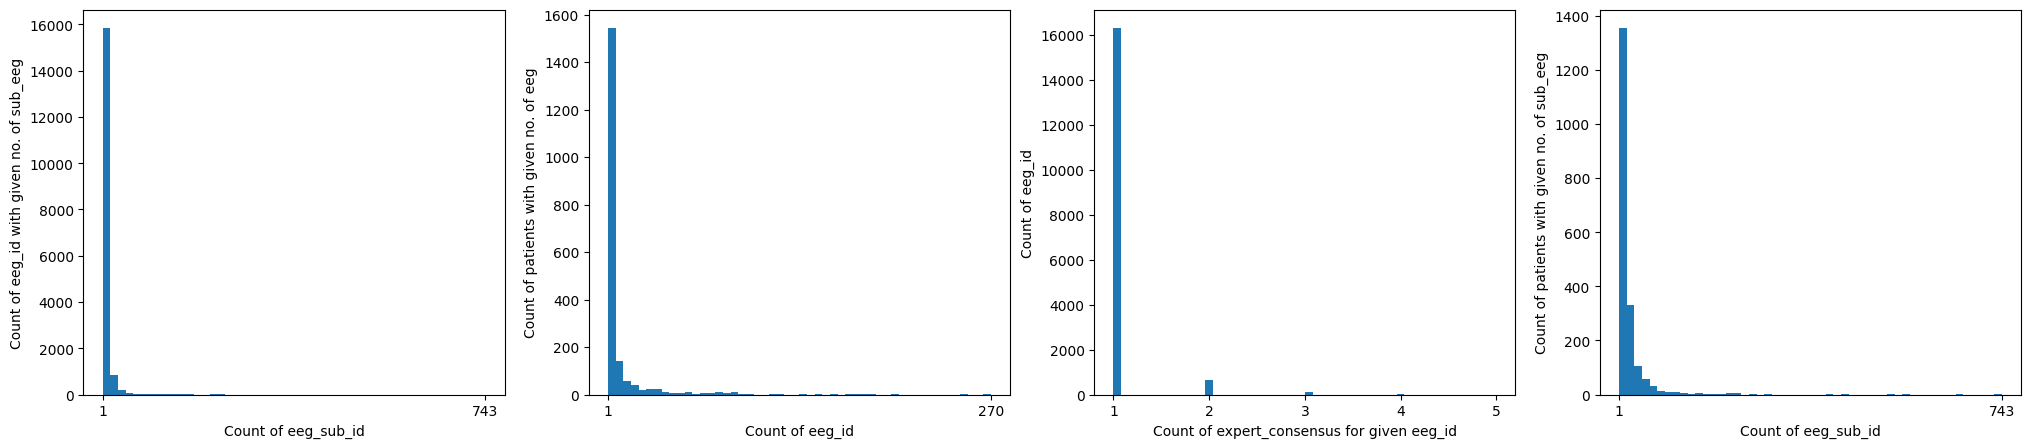

In [5]:
%%time
fig, axs = plt.subplots(1,4, figsize = (25,5))

df = train_df.group_by('eeg_id').agg(pl.col('eeg_sub_id').n_unique())

axs[0].hist(df['eeg_sub_id'], bins = 50)
axs[0].set_xlabel('Count of eeg_sub_id')
axs[0].set_ylabel('Count of eeg_id with given no. of sub_eeg')
axs[0].set_xticks((df['eeg_sub_id'].min() , df['eeg_sub_id'].max()))

# eeg vs patient
df = train_df.group_by('patient_id').agg(pl.col('eeg_id').n_unique())
axs[1].hist(df['eeg_id'], bins = 50)
axs[1].set_xlabel('Count of eeg_id')
axs[1].set_ylabel('Count of patients with given no. of eeg')
axs[1].set_xticks((df['eeg_id'].min() , df['eeg_id'].max()))

df = train_df.group_by('eeg_id').agg(pl.col('expert_consensus').n_unique())
axs[2].hist(df['expert_consensus'], bins = 50)
axs[2].set_ylabel('Count of eeg_id')
axs[2].set_xlabel('Count of expert_consensus for given eeg_id')
axs[2].set_xticks([1,2,3,4,5])

df = train_df.group_by('patient_id').agg(pl.col('eeg_sub_id').n_unique())

axs[3].hist(df['eeg_sub_id'], bins = 50)
axs[3].set_xlabel('Count of eeg_sub_id')
axs[3].set_ylabel('Count of patients with given no. of sub_eeg')
axs[3].set_xticks((df['eeg_sub_id'].min() , df['eeg_sub_id'].max()))
print()

In [6]:
eeg_ids = train_df.group_by('eeg_id').agg( pl.col("eeg_label_offset_seconds"))
eeg_ids.head()

eeg_id,eeg_label_offset_seconds
i64,list[f64]
213567607,"[0.0, 4.0, … 10.0]"
2831354131,"[0.0, 4.0]"
1047741956,"[0.0, 16.0, 22.0]"
2126786541,[0.0]
1151426487,"[0.0, 4.0, … 10.0]"


In [13]:
eeg_ids = train_df.group_by('eeg_id').agg( pl.col("eeg_label_offset_seconds"))

time =[]
nan_count = []
for i in tqdm.tqdm(range(len(eeg_ids))):
    row = eeg_ids.row(index = i, named = True)
    eeg_id=row['eeg_id']
    eeg_parquet = pl.read_parquet(os.path.join(BASE_DIR , 'train_eegs' , str(eeg_id)+'.parquet'))
    for j, offset in enumerate(row['eeg_label_offset_seconds']):
        sub_eeg = get_eeg(eeg_parquet, offset)
        time_stamps = len(sub_eeg)
        time.append(time_stamps)
        ct = np.array(sub_eeg.null_count().row(index=0))
        nan_count.append(ct)
        
    if i==1000:
        break
    
nan_count = np.array(nan_count)
dict_ = {
    'time' : time , 
    'nan_count' : nan_count
}

with open(f'{SAVING_DIR}/eeg_distributions.pkl', "wb") as f:
    pickle.dump(dict_, f)
        

  6%|▌         | 1000/17089 [00:08<02:13, 120.85it/s]


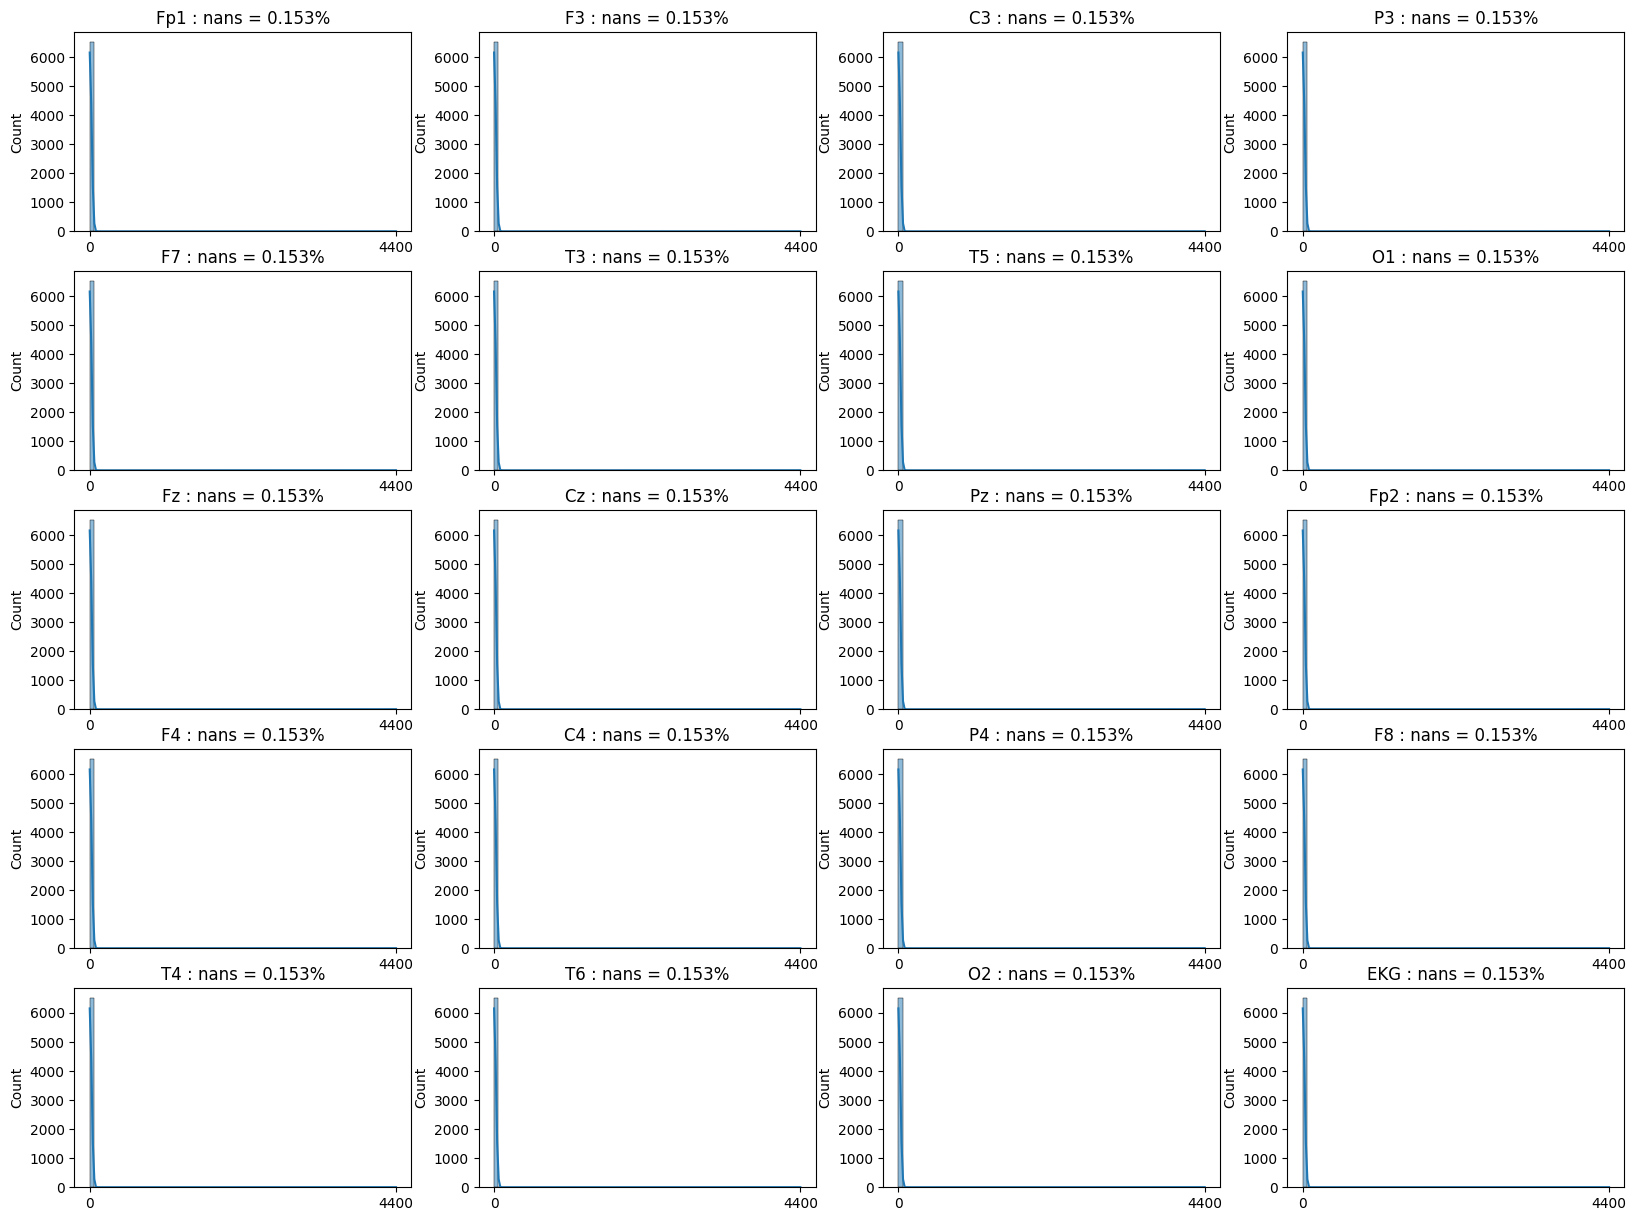

<Figure size 640x480 with 0 Axes>

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

with open(f'{SAVING_DIR}/eeg_distributions.pkl',"rb") as f:
    data = pickle.load(f)
    
# nan_count = data['nan_count']
fig, ax = plt.subplots(5,4 ,figsize = (20,15))
cols = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']

for i in range(20):
    r, c = i//4 , i%4
    electrode_nans = nan_count[:, i]
    sns.histplot(electrode_nans , bins = 70 , ax = ax[r,c], kde=True)
    ax[r,c].set_xticks((0 , max(electrode_nans)))
    ct = sum(1 for element in electrode_nans if element > 1000)
    percent_nans = round(ct/len(nan_count)*100, 3)
    ax[r,c].set_title(f'{cols[i]} : nans = {percent_nans}%')

plt.show()
plt.savefig("nans_eeg_analysis.png") 


**Following conclusions can be drawn from above plots:**

* Most of the eeg have 1 sub_eeg, but there are few eeg with its sub-parts as high as 743
* Most of the patients have contributed 1 eeg, but there are few patients who have contributed about 270 eeg
* Almost all eeg have single expert_consensus, but there are few eeg where expert_consensus varies with its sub-eeg's

## **Reducing Data-points**
* There are 1lac+ sub-eeg data-points, going for model training with such a huge data-set would be cumbersome.
* I can think of following criteria for filtering out data-points:
    - Try filtering those eeg-id which have more than **k** eeg_sub_id.
    - Among these, filter out sub_eeg_id, which have **nan_count more than a threshold value** .
    - Try to keep a **set of sub_eeg_id with diverse set of expert_consensus**.

## **Signal Processing using MNE**

Doing signal processing on **Seizure**

In [ ]:
# !pip install "mne>=1.0" matplotlib mne-qt-browser
!pip install pyqt6
!pip install PyQt6


In [ ]:
labels = list(set(train_df['expert_consensus']))

activity = "LPD"
# dict_ = {}
row = train_df.group_by("expert_consensus"==activity).agg(pl.col("eeg_id").max() , pl.col("eeg_label_offset_seconds").median()).row(0, named = True)

eeg = pl.read_parquet(os.path.join(BASE_DIR, 'train_eegs' ,str(row['eeg_id'])+'.parquet'))
seizure_eeg = get_eeg(eeg , row['eeg_label_offset_seconds'])

seizure_eeg.write_parquet(os.path.join('/kaggle/working/', f'{activity}.parquet'))
seizure_eeg.shape
# mne.viz.set_browser_backend("qt")
# for i in range(len(df)):
#     row = df.row(i, named = True)
#     eeg_path = os.path.join(BASE_DIR , 'train_eegs' , str(row['eeg_id'])+'.parquet')
#     eeg = pl.read_parquet(eeg_path)
    
#     sub_eeg = get_eeg(eeg , row['eeg_label_offset_seconds'])
#     dict_[row['expert_consensus']] = sub_eeg
# matplotlib.use('Qt5Agg')

# sfreq = 200 
# info = mne.create_info(ch_names = seizure_eeg.columns, sfreq = sfreq)
# raw = mne.io.RawArray(seizure_eeg.transpose(), info)
# # raw.plot(block=True, bad_color= 'red', use_opengl=True)
# print(1)

# plt.switch_backend('QtAgg')

# raw.plot(scaling = "auto", use_opengl = True)
# plt.pause(0.0001) 
# %matplotlib

# # raw.compute_psd(fmax=50).plot()

In [ ]:
# k = 6

# def filter_rows(data:pl.DataFrame , id_:int , null_threshold:int = 0.5, is_eeg = True)->pl.DataFrame:
#     x = "eeg" if is_eeg else "spectrogram"
#     BASE_DIR =  f'/kaggle/input/hms-harmful-brain-activity-classification/train_{x}s'
#     sub_id_df = data.filter(pl.col(f'{x}_id')== id_).with_row_count(name="my_index")

#     parquet_file = pl.read_parquet(os.path.join(BASE_DIR , str(id_)+'.parquet'))

#     low_null_sub_id = []
#     for i in range(len(sub_id_df)):
#         row = sub_id_df.row(i , named = True)
#         if is_eeg:
#             sub_report = get_eeg(parquet_file , row[f'{x}_label_offset_seconds'])
#         else :
#             sub_report = get_spec(parquet_file, row[f'{x}_label_offset_seconds'])
        
#         try:
#             null_count = sub_report.null_count()
#             null_percentage = null_count.with_columns(sum= pl.sum_horizontal(null_count.columns))[0, 'sum'] / len(sub_report)
        
#             if null_percentage < null_threshold:
#                 low_null_sub_id.append(row['eeg_sub_id'])
#         except:
#             continue
            
#     if len(low_null_sub_id) == 0:
#         return None
    
#     # now randomly selecting a set of eeg_sub_id, to ensure diverse expert_consensus
#     expert_consensus = sub_id_df.filter(pl.col('eeg_sub_id').is_in(low_null_sub_id))['expert_consensus']

#     random_sub_id = np.argsort(np.random.rand(len(expert_consensus)))
#     random_sub_id = random_sub_id[:min(k , len(low_null_sub_id))]

#     filtered_df = sub_id_df.filter(pl.col("my_index").is_in(random_sub_id))
    
#     return filtered_df.select(pl.exclude(['my_index']))

# #-------------------------------------------------------------------------------------------------------
# FILTER_SUB_EEG = False

# if FILTER_SUB_EEG:
#     eeg_final_df = None
#     eeg_ids = train_df.select(pl.col('eeg_id')).unique()
#     for i in tqdm.tqdm(range(len(eeg_ids))):
#         eeg_id = eeg_ids.row(i, named = True)['eeg_id']
#         filtered_df = filter_rows(train_df , eeg_id)
#         if filtered_df is not None:
#             if eeg_final_df is None:
#                 eeg_final_df = filtered_df
#             else :
#                 eeg_final_df = pl.concat([eeg_final_df , filtered_df])
#         if i%150==0 and i>0:
#             time.sleep(2)

#     eeg_final_df.write_csv(os.path.join(SAVING_DIR, 'eeg_final_df.cvs'))
# else : 
#     eeg_final_df = pl.read_csv('/kaggle/input/custom-brain-activity-dataset/eeg_final_df.cvs')

# print('filtered eeg final shape after filtering : ',eeg_final_df.shape)

In [ ]:
# FILTER_SUB_SPEC = False

# if FILTER_SUB_SPEC:
#     spec_final_df = None
#     spec_ids = eeg_final_df.select(pl.col('spectrogram_id')).unique()
#     for i in tqdm.tqdm(range(len(spec_ids))):
#         spec_id = spec_ids.row(i, named = True)['spectrogram_id']
#         filtered_df = filter_rows(eeg_final_df , spec_id, is_eeg = False)
#         if filtered_df is not None:
#             if spec_final_df is None:
#                 spec_final_df = filtered_df
#             else :
#                 spec_final_df = pl.concat([spec_final_df , filtered_df])
#         if i%150==0 and i>0:
#             time.sleep(2)

#     spec_final_df.write_csv(os.path.join(SAVING_DIR, 'spec_final_df.cvs'))
# else : 
#     spec_final_df = pl.read_csv('/kaggle/input/custom-brain-activity-dataset/spec_final_df.cvs')

# print('filtered spec final shape after filtering : ',spec_final_df.shape)

## **Splitting dataset**
* Rn, I preterer to **split the train_df on basis of expert_consensus** with a belief that there would be equal proportion of type of eeg in each of train, val, test parts

In [ ]:
# eeg_final_df = eeg_final_df.with_columns(eeg_file_name = (pl.col('eeg_id').cast(pl.String) + "-" + pl.col('eeg_sub_id').cast(pl.String)))
# spec_final_df = spec_final_df.with_columns(spec_file_name = (pl.col('spectrogram_id').cast(pl.String) + "-" + pl.col('spectrogram_sub_id').cast(pl.String)))

# eeg_trainX = eeg_final_df.select(pl.exclude(['seizure_vote', 'lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']))
# eeg_trainY = eeg_final_df.select(pl.col(['seizure_vote', 'lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']))

# eeg_trainY/= eeg_trainY.sum_horizontal()


In [ ]:
# spec_trainX = spec_final_df.select(pl.exclude(['seizure_vote', 'lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']))
# spec_trainY = spec_final_df.select(pl.col(['seizure_vote', 'lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']))

# spec_trainY/= spec_trainY.sum_horizontal()

In [ ]:
# eeg_X_train, eeg_X_test, eeg_Y_train, eeg_Y_test = train_test_split(eeg_trainX, eeg_trainY, test_size=0.2,stratify = eeg_trainX['expert_consensus'] ,random_state=42)
# eeg_X_train, eeg_X_val, eeg_Y_train, eeg_Y_val = train_test_split(eeg_X_train, eeg_Y_train, test_size=0.2,stratify = eeg_X_train['expert_consensus'] ,random_state=42)


# eeg_X_train.write_csv(os.path.join(SAVING_DIR, 'eeg_X_train.cvs'))
# eeg_X_test.write_csv(os.path.join(SAVING_DIR, 'eeg_X_test.cvs'))
# eeg_X_val.write_csv(os.path.join(SAVING_DIR, 'eeg_X_val.cvs'))
# eeg_Y_train.write_csv(os.path.join(SAVING_DIR, 'eeg_Y_train.cvs'))
# eeg_Y_test.write_csv(os.path.join(SAVING_DIR, 'eeg_Y_test.cvs'))
# eeg_Y_val.write_csv(os.path.join(SAVING_DIR, 'eeg_Y_val.cvs'))

# print(f'train_data :{len(eeg_X_train)}\nval_data : {len(eeg_X_val)}\ntest_data : {len(eeg_X_test)}')

In [ ]:
# spec_X_train, spec_X_test, spec_Y_train, spec_Y_test = train_test_split(spec_trainX, spec_trainY, test_size=0.2,stratify = spec_trainX['expert_consensus'] ,random_state=42)
# spec_X_train, spec_X_val, spec_Y_train, spec_Y_val = train_test_split(spec_X_train, spec_Y_train, test_size=0.2,stratify = spec_X_train['expert_consensus'] ,random_state=42)


# spec_X_train.write_csv(os.path.join(SAVING_DIR, 'spec_X_train.cvs'))
# spec_X_test.write_csv(os.path.join(SAVING_DIR, 'spec_X_test.cvs'))
# spec_X_val.write_csv(os.path.join(SAVING_DIR, 'spec_X_val.cvs'))
# spec_X_train.write_csv(os.path.join(SAVING_DIR, 'spec_Y_train.cvs'))
# spec_Y_test.write_csv(os.path.join(SAVING_DIR, 'spec_Y_test.cvs'))
# spec_Y_val.write_csv(os.path.join(SAVING_DIR, 'spec_Y_val.cvs'))

# print(f'train_data :{len(spec_X_train)}\nval_data : {len(spec_X_val)}\ntest_data : {len(spec_X_test)}')

## **Signal Processing** 

In [ ]:
def eeg_signal_process(x):
    return x

def spec_signal_process(x):
    return x

#TODO : analyse all 6 categories of brain activities in detail, visualize them, write code

## **Saving eeg's to .npy**

* There are a lot of .parquet files in the dataset, reading each of them would consume a lot of time.
* So, to save time, I choose to store all sub_eeg in a dictionary and save it as single .npy file.

In [ ]:
# import shutil

# os.listdir('/kaggle/working/')
# os.remove('/kaggle/working/spectrogram.zip')
# shutil.rmtree('/kaggle/working/spectrogram')
# shutil.rmtree('/kaggle/working/eeg')


In [ ]:
# %%time

# EEG_BASE_DIR = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
# Spec_BASE_DIR = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms'


# def create_npy(data:pl.DataFrame, base_dir, processing_func = None, is_eeg = True, sampling_freq= 200):
#     x = "eeg" if is_eeg else "spectrogram"
#     saving_dir = os.path.join(SAVING_DIR , x)
#     if not os.path.exists(saving_dir):
#         os.mkdir(saving_dir)
        
#     for i ,id_ in enumerate(set(data[f'{x}_id'])):
#         file_path = os.path.join(base_dir , str(id_)+'.parquet')
#         parquet_file = pl.read_parquet(file_path)
        
#         # the given sampling rate is 200Hz
#         # As we are interested in low frequencies, we can down-sample to 50Hz sampling rate
#         # Reference : https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468684#2607480
        
#         rows = data.filter(pl.col(f'{x}_id') == id_)

#         for j in range(len(rows)):
#             row = rows.row(j, named = True)
#             sub_id = row[f'{x}_sub_id']
            
#             if is_eeg:
#                 series = get_eeg(parquet_file, row[f'{x}_label_offset_seconds'], sampling_freq)
#             else :
#                 series = get_spec(parquet_file , row[f'{x}_label_offset_seconds'])

#             if processing_func is not None:
#                 series = processing_func(series)

#             np.save(os.path.join(saving_dir, f'{id_}-{sub_id}.npy'), series)
        
#         if i%100==0 and i>0:
#             time.sleep(2)   # to avoid cpu crashes
#             gc.collect()    # to avoid ram crashes
#             print(f'{i} : called garbage collector', "\u2764\ufe0f")
            
                
        
# CREATE_EEG_NPY = False
# CREATE_Spec_NPY = False

# if CREATE_EEG_NPY:
#     create_npy(eeg_final_df, EEG_BASE_DIR, processing_func = eeg_signal_process, sampling_freq = 50)
#     print('radhe radhe')
#     shutil.make_archive('/kaggle/working/eeg', 'zip', '/kaggle/working/' ,'eeg/')
# #     shutil.unpack_archive('/kaggle/working/eeg.zip', '/kaggle/working/EEG_extracted', "zip") 


# if CREATE_Spec_NPY:
#     create_npy(spec_final_df, Spec_BASE_DIR, processing_func = spec_signal_process, is_eeg = False )
#     print('hare krishna')
#     shutil.make_archive('/kaggle/working/spectrogram', 'zip', '/kaggle/working/' ,'spectrogram/' )
    
# # x = np.load('/kaggle/working/eeg.npy', allow_pickle = True).item()
# # x['1628180742_0']

In [ ]:
# !ls

In [ ]:
# from IPython.display import FileLink
# FileLink(r'spec_final_df.cvs')

In [ ]:
# submission = pl.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv')
# display(submission.head())

# test_df = pl.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
# display(test_df)

In [ ]:
# test_eeg = pl.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/3911565283.parquet')
# test_eeg.shape